# E-11-(연습) 뉴스 요약봇 만들기

## 텍스트 요약(Text Summarization)

* 추출적 요약(Extractive Summarization) : 원문에서 문장들을 추출해서 요약하는 방식  
* 추상적 요약(Abstractive Summarization) : 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것, 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미

## 인공 신경망으로 텍스트 요약 훈련시키기

* seq2seq 모델을 이용하여 Abstractive summarization 방식의 텍스트 요약기 만들기

* seq2seq  
* LSTM과 컨텍스트 벡터 : seq2seq 구현 시, 인코더/디코더로 바닐라 RNN이 아닌 LSTM 사용  
* 시작 토큰과 종료 토큰 : 훈련 데이터의 예측 대상 시퀀스의 앞/뒤에는 시작 토큰과 종료 토큰을 넣어주는 전처리를 통해 어디에서 멈춰야하는지 알려줘야 함  
* 어텐션 메커니즘을 통한 새로운 컨텍스트 벡터 사용하기

##### 위 내용 요약 정리  
   1. seq2seq를 사용합니다.  
   2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.  
   3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.  
   4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.  
   5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.  
   6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

## 1. 데이터 준비하기

* 아마존 리뷰 데이터셋 다운로드(`Reviews.csv`) : https://www.kaggle.com/snap/amazon-fine-food-reviews  
* NLTK의 불용어(stopwords)를 사용 : NTLK와 NLTK 데이터셋이 설치되어있지 않은 환경이라면 NLTK를 설치하고 NTLK의 데이터셋을 다운로드
* NTLK 다운로드 : `pip install nltk`  
* BeautifulSoup 라이브러리(문서를 파싱하는데 사용하는 패키지) 설치 : `pip install beautifulsoup4`

In [1]:
# nltk 패키지에서 불용어 사전을 다운로드 받고, 데이터 전처리를 위한 나머지 패키지도 함께 불러오기

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj42/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 링크에서 다운로드 받은 데이터(Reviews.csv)에는 총 568,454개의 샘플 있음
# 시간상 모든 샘플을 사용하지는 않고, 10만개만 사용해볼 것임
# 주의!! : 데이터 파일의 경로를 수정하는 것 잊지 말기

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows = 100000)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 100000


In [3]:
# 십만 개의 샘플 중 5개만 출력해보기

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# 전체 데이터 중 필요한 Summary열과 Text열만 훈련에 사용, 이 두 개의 열만 별도로 저장하고 다시 출력하기

data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
96985,"Like many moms, I have discovered that my todd...",happy to let my kid eat this by the spoonful!
75531,I discovered this product in 2011. Loacker Qua...,Absolutely delicious
62188,Royal Oak Virginia Crabbers are a great produc...,Last year's crop!
23224,You either love em or hate em. I personally l...,I love me some lemonheads.
17452,This is one of my favorite bold coffees. It i...,Excellent Coffee
31322,I got a similar variety pack at Costco and eve...,Delicious!!!!!
33907,I have used this product for quite some time o...,It works!
318,"service was great, but I meant to buy Swiss Ch...",Swiss Chalet
29707,I discovered Bigelow's Vanilla Carmel tea a co...,Fantastic hot or iced
5963,My dogs love these and even my allergy dogs ca...,Old Mother Hubbard Crunchy Classic Snacks for ...


* 이 실습에선 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 것임

## 2. 데이터 전처리하기

### (1) 데이터 정리하기

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
# 데이터의 중복 샘플 유무 확인

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

# Text가 달라도 Summary는 동일할 수 있음
# 하지만 Text 자체가 중복된 경우는 중복 샘플이므로 제거해야 함

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# 데이터프레임의 drop_duplicates()를 사용하여 중복 샘플 제거

data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수 :',(len(data)))

# 그런데 만약 데이터 Null값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만,
# 여전히 Null값 한개가 어딘가 남아있을 수 있음

전체 샘플수 : 88426


In [7]:
# 데이터프레임에 Null 값이 있는지 확인 : .isnull().sum()을 사용

print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
# 데이터프레임에서 Null 제거 : dropna() 함수 사용

data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


#### 텍스트 정규화와 불용어 제거

* 텍스트 정규화(text normalization) : 단어들 중 같은 의미 다른 표현들을 (예 : it'll/it will, mustn't/must not) 기계 학습 전에 미리 같은 표현으로 통일시켜 기계의 연산량 줄이기  
* 정규화 사전 출처 : https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [9]:
# 텍스트 정규화를 위한 사전(dictionary) 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [10]:
# 샘플에서 불용어를 제거 : NLTK에서 제공하는 불용어 리스트를 참조

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 전처리 전, 후의 결과를 확인하기 위해 임의의 text와 summary를 만들어 함수를 호출
# (코드 오류가 난다면 parser가 설치되어있지 않은 것이니, lxml을 설치 : pip install lxml)

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

# 결과 : 모두 소문자로 변환, html 태그 제거, 괄호나 특수문자 제거

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [13]:
# 훈련 데이터 전체에 전처리 수행
# 이때, Text의 경우 불용어 제거하고, Summary의 경우 불용어를 제거하지 않을 것이므로 따로 호출하여 진행
# 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보기

clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [14]:
# 이제 Summary에 대해서 전처리 함수를 호출해줄 때, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어주기

clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

# 텍스트 정제 과정을 거친 후, 다시 한번 빈(empty) 샘플이 생겼는지 확인
# 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있음
# 이렇게 되면 샘플 자체가 빈 값을 가지게 됨

/home/aiffel-dj42/anaconda3/envs/aiffel/lib/python3.7/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [15]:
# 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장하고 빈(empty) 값을 갖는 샘플들은 모두 Null 값을 가진 샘플로 대체

data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
# .isnull().sum()을 사용하여 Null 값이 생겼는지 확인

data.isnull().sum()

# Summary 열에서 70개의 Null 값이 생성
# 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개 생겼다는 의미

Text        0
Summary    70
dtype: int64

In [17]:
# Null 샘플들 모두 제거

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))  #데이터 전처리 함수

전체 샘플수 : 88355


### (2) 훈련데이터와 테스트데이터 나누기

* 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝 표시하기

#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


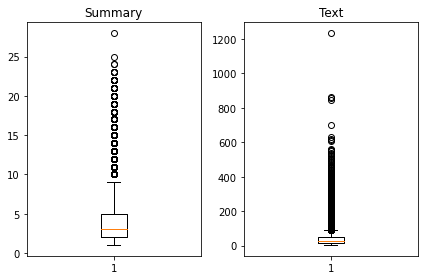

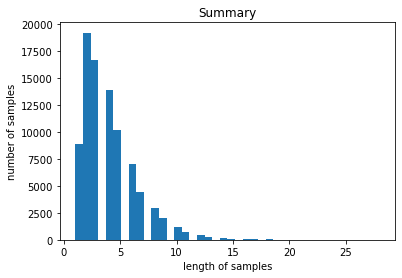

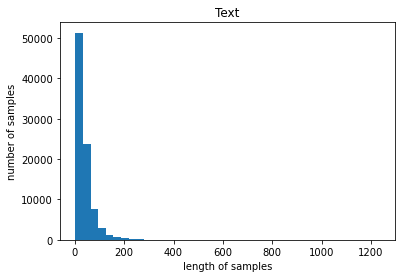

In [18]:
# Text와 Summary의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화하여 확인

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서 부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 갯수, 실제 텍스트 샘플 길이별 갯수를 나타내고 있어요.  
  
Text의 경우 최소 길이가 2, 최대 길이가 1,235으로 그 차이가 굉장히 크죠. 하지만 평균 길이는 38로 시각화 된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있어요.  
  
Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

In [19]:
# Text의 최대 길이와 Summary의 적절한 최대 길이 임의로 정해보기

text_max_len = 50
summary_max_len = 8

# 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는데 도움이 될 것임

In [20]:
# 좀 더 정확한 판단을 위하여, 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산하는 함수 만들기

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
# 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 확인해 보기

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

# 결과 : 각각 50과 8로 패딩을 하게되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데,
# Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다함

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [22]:
# 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


#### 시작 토큰과 종료 토큰 추가하기

In [23]:
# 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가
# 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,
# 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 하기
# 두 개의 문장 모두 Summary 열로부터 만들 것임

#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [24]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [25]:
# 훈련 데이터와 테스트 데이터 분리 : 분리 패키지를 사용하는 방법과 직접 코딩을 통해서 분리하는 방법 중 직접 코딩하여 분리

# 1. encoder_input과 크기 및 형태가 같은 순서가 섞인 정수 시퀀스 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[22351 42100 29806 ... 42115  5489  3257]


In [26]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주어 잘 섞인 샘플 만들기

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13163


In [28]:
# 테스트 데이터의 개수를 이용하여 전체 데이터 분할
# :표시의 위치에 주의

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


### (3) 정수 인코딩

#### 단어 집합(vocaburary) 만들기 및 정수 인코딩

In [29]:
# 훈련 데이터에 대해서 단어 집합을 만들어보기
# 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들기
# Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

# 이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어있음
# 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행할 것임

In [30]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해 통계적인 정보를 얻음

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)   # encoder_input_train에 있는 총 단어수
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31981
등장 빈도가 6번 이하인 희귀 단어의 수: 23722
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8259
단어 집합에서 희귀 단어의 비율: 74.17529157937525
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3765843000014963


In [31]:
# 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
# 위에서 이를 제외한 단어 집합의 크기가 대략 8000 안팍으로 계산되는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8000으로 제한
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [32]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩 수행
# 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에 데이터에 존재하지 않음

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

# 결과 : 텍스트를 정수로 바꿨으니까 정수로 출력

[[134, 3897, 2415, 902, 886, 24, 718, 616, 3526, 106, 1065, 634, 622, 2645, 36, 3, 224, 64, 3801, 10, 4, 1332, 413, 1175], [1924, 151, 892, 12, 127, 712, 203, 517, 151, 156, 552, 28, 302, 122, 232, 4, 2, 491, 7, 984, 57, 212, 4, 2], [5, 251, 903, 123, 1203, 1171, 521, 627, 5, 16, 43, 453, 121, 5, 18, 256, 5, 227]]


In [33]:
# Summary 데이터에 대해서도 동일한 작업 수행
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되고 이는 tar_tokenizer.word_index에 저장
# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장

In [34]:
# 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10565
등장 빈도가 5번 이하인 희귀 단어의 수: 8199
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2366
단어 집합에서 희귀 단어의 비율: 77.60530052058684
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.9080652440203725


In [35]:
# 위와 마찬가지로 등장빈도가 적은 희귀 단어들(대략 2000개) 제거 : 단어집합 크기 제한

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 391], [1, 149], [1, 1215, 631, 661], [1, 4, 13], [1, 1365, 1065, 158, 130, 11]]
target
decoder  [[391, 2], [149, 2], [1215, 631, 661, 2], [4, 13, 2], [1365, 1065, 158, 130, 11, 2]]


##### 패딩 작업 전 점검 사항  
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.  
  
요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올거에요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을테니까요.

In [36]:
# 훈련 데이터와 테스트 데이터에서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
# 이 샘플들은 모두 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1281
삭제할 테스트 데이터의 개수 : 316
훈련 데이터의 개수 : 51374
훈련 레이블의 개수 : 51374
테스트 데이터의 개수 : 12847
테스트 레이블의 개수 : 12847


/home/aiffel-dj42/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩하기

In [37]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 후, 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 필요
# 아까 정해두었던 최대 길이로 패딩함
# 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주기

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 학습에 필요한 전처리 끝!!!!!

## 3. 모델 설계하기

In [38]:
# 함수형 API를 이용하여 인코더를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴론의 갯수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.  
  
인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

In [39]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [40]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.  
  
지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

#### 어텐션 매커니즘  
* 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻  
* 참고1 : https://wikidocs.net/73161  
* 참고2 : https://www.youtube.com/watch?v=WsQLdu2JMgI

In [41]:
# 깃허브에 공개되어져 있는 어텐션 함수를 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었음

In [42]:
# 설계한 디코더의 출력층을 다음과 같이 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
# 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 4. 모델 훈련하기

In [43]:
# 모델 훈련(학습)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# EarlyStopping : 조기 종료, 특정 조건이 충족되면 모델의 훈련을 멈추는 역할
# 여기서는 val_loss(검증 데이터의 손실)을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patiensce =2
# 즉, 2회 관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
201/201 [==============================] - 66s 327ms/step - loss: 2.7039 - val_loss: 2.3830
Epoch 2/50
201/201 [==============================] - 65s 324ms/step - loss: 2.3788 - val_loss: 2.2463
Epoch 3/50
201/201 [==============================] - 65s 325ms/step - loss: 2.2477 - val_loss: 2.1409
Epoch 4/50
201/201 [==============================] - 67s 332ms/step - loss: 2.1300 - val_loss: 2.0471
Epoch 5/50
201/201 [==============================] - 68s 339ms/step - loss: 2.0425 - val_loss: 1.9952
Epoch 6/50
201/201 [==============================] - 72s 360ms/step - loss: 1.9786 - val_loss: 1.9561
Epoch 7/50
201/201 [==============================] - 72s 359ms/step - loss: 1.9266 - val_loss: 1.9319
Epoch 8/50
201/201 [==============================] - 72s 359ms/step - loss: 1.8801 - val_loss: 1.9038
Epoch 9/50
201/201 [==============================] - 72s 360ms/step - loss: 1.8409 - val_loss: 1.8831
Epoch 10/50
201/201 [==============================] - 71s 353ms/step - l

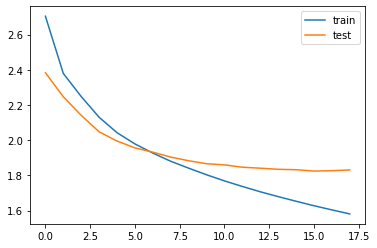

In [44]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5. 인퍼런스 모델 구현하기

In [45]:
# 테스트 단계에서 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 미리 준비

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

##### seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행  
훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비  
  
그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함  
  
이 때는 인코더 모델과 디코더 모델을 분리해서 설계

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 6. 모델 테스트하기

In [49]:
# 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어 두기
# 1. Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고
# 2. Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : lowrey probably best pork rinds available usa always fresh proper time micro wave 
실제 요약 : best 
예측 요약 :  best peanuts ever


원문 : first tried tasty almonds amazed great flavor kick wasabi sweet taste roasted almonds first one eye opener time even many times bold fun like sushi enjoy taste wasabi 
실제 요약 : different and tasty 
예측 요약 :  delicious


원문 : sent lb bag son iraq said best gummi bears ever eaten bought world haribo original manufacturer gummi bears remember order gold bears highly recommend thanks amazon 
실제 요약 : best ever 
예측 요약 :  gummi bears


원문 : tried five years ago greek cafe sweet pungent flavor anise looked years without success days ago ordered arrived day estimated arrival could happier price wonderful 
실제 요약 : wonderful flavor 
예측 요약 :  best maple syrup ever


원문 : wish breakfast items tasted good almost like eating cookie breakfast tip heat makes taste even better 
실제 요약 : perfect tasty breakfast 
예측 요약 :  good for gluten free


원문 : wife brought five differe

예측 요약 :  great product


원문 : love salsa best salsa ever eaten order salsa crave cannot find stores would recommend salsa day 
실제 요약 : love salsa 
예측 요약 :  best olive oil ever


원문 : soap turn mushy excellent skin natural really smart bargain 
실제 요약 : lasting 
예측 요약 :  best dressing ever


원문 : disappointed display show china trying avoid made china 
실제 요약 : disappointed 
예측 요약 :  made in china


원문 : looking special treat special dog believe produce fill need small mouth dog 
실제 요약 : service dogs treats 
예측 요약 :  my dogs love these


원문 : perfect entertain coffee also conversation win win 
실제 요약 : for the 
예측 요약 :  great for the price


원문 : pure smooth sugar sweet best price since sams club stop selling syrup 
실제 요약 : real syrup 
예측 요약 :  great product


원문 : great way sweeten anything plus toffee flavor makes even plain coffee taste like scrumptious desert yummy 
실제 요약 : tasty stevia 
예측 요약 :  great taste


원문 : admit bought gluten free foods web site completely missed calorie descr

## 7. 추출적 요약 해보기

앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.  
  
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

#### 패키지 설치  
* `pip install summa`

#### 데이터 다운로드하기

In [51]:
import requests
from summa.summarizer import summarize

In [52]:
# 매트릭스 시놉시스를 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

# text에 매트릭스 시놉시스가 문자열로 저장되었음

In [53]:
# 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해보기

print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

#### summarize 사용하기

* text (str) : 요약할 테스트  
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
* words (int or None, optional) – 출력에 포함할 단어 수  
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시  
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환 

In [54]:
# Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
# 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음
# 비율을 적게 주어 요약문으로 선택되는 문장의 개수를 줄여보기
# 원문의 0.005%만을 출력하도록 설하

print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [55]:
# 리스트로 출력 결과를 받고 싶으면 split 인자의 값을 True로 하기

print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [56]:
# 단어의 수로 요약문의 크기를 조절 가능
# 단어를 50개만 선택하도록 설정

print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
